In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from LSsurf.unique_by_rows import unique_by_rows
import pointCollection as pc
import glob
import re
import h5py
import pandas as pd

In [10]:
import scipy.stats as sps

In [60]:
def read_xovers(xover_dir, verbose=False, wildcard='*', r_limits=[0, 1.e7], delta_t_limit=2592000):
    tiles=glob.glob(xover_dir+'/*.h5')
    with h5py.File(tiles[0],'r') as h5f:
        fields=[key for key in h5f['data_0'].keys()]
    
    D=[]
    meta=[]
    #X=[]
    tile_re=re.compile('E(.*)_N(.*).h5')
    count=0
    tiles=glob.glob(xover_dir+'/'+wildcard+'.h5')
    for tile in tiles:
        m=tile_re.search(tile)
        if m is not None:
            r2=np.float(m.group(1))**2+np.float(m.group(2))**2
            if (r2 < r_limits[0]**2) or (r2 > r_limits[1]**2):
                continue
        try:
            this_D=[pc.data().from_h5(tile, field_dict={gr : fields}) for gr in ['data_0','data_1']]
            if delta_t_limit is not None:
                good=np.abs(this_D[1].delta_time[:,0]-this_D[0].delta_time[:,0]) < delta_t_limit
                for Di in this_D:
                    Di.index(good)
                try:
                    this_meta=pc.data().from_h5(tile, field_dict={None:['slope_x', 'slope_y','grounded']})
                    this_meta.index(good)
                except Exception:
                    this_meta=None
            count += 1
        except KeyError:
            if verbose:
                print("failed to read " + tile)
            continue

        D.append(this_D)
        if this_meta is not None:
            meta.append(this_meta)
        #if np.mod(count, 100)==0:
        #    print(f'{count} out of {len(tiles)}')
    
    v={}
    for field in fields:
        vi=[]
        for Di in D:
            vi.append(np.r_[[np.sum(getattr(Di[ii], field)*Di[ii].W, axis=1) for ii in [0, 1]]])
        v[field]=np.concatenate(vi, axis=1).T
    delta={field:np.diff(v[field], axis=1) for field in fields}
    bar={field:np.mean(v[field], axis=1) for field in fields}
    try:
        meta=pc.data().from_list(meta)
        meta={key:getattr(meta, key) for key in meta.fields}
    except Exception:
        pass
    return v,  delta,  bar, meta

In [3]:
def spread_vs_slope(delta0, rounded_slope_0, ind=None):
    if ind is not None:
        delta=delta0.copy_subset(ind)
        rounded_slope=rounded_slope_0[ind]
    else:
        delta=delta0
        rounded_slope=rounded_slope_0
    _, slope_bins = unique_by_rows(rounded_slope, return_dict=True)
    slope_vals=np.zeros(len(slope_bins.keys()))+np.NaN
    spread=np.zeros_like(slope_vals)+np.NaN
    N=np.zeros_like(slope_vals)+np.NaN
    for ii, key in enumerate(slope_bins.keys()):
        slope_vals[ii]=np.nanmedian(rounded_slope[slope_bins[key]])
        dsub=delta.h_li[slope_bins[key]]
        ind=np.ones_like(dsub, dtype=bool)
        for k in np.arange(6):
            sigma=np.sqrt(np.nanmean(dsub[ind]**2))
            ind = np.abs(dsub) < 3*sigma
        spread[ii]=sigma #ss.scoreatpercentile(np.abs(dsub), 0.68)
        N[ii]=np.sum(ind)
    return slope_vals, spread, N           

def slope_regression(slope, spread, max_slope):
    these= (slope < max_slope)
    G=np.ones((np.sum(these), 2))
    G[:,1]=slope[these]**2
    m=np.linalg.solve(G.T.dot(G), G.T.dot(spread[these]**2))
    V_model=G.dot(m)
    V_model[V_model<0]=np.NaN
    return [np.sqrt(m[0]), np.sqrt(m[1])], np.sqrt(V_model)



In [4]:
def read_cycle(release, cycle):
    xover_dir='/Volumes/ice2/ben/scf/AA_06/'+release+'/xovers/'+cycle+'/'
    ATL06_fields=['BP','LR','W','cycle_number','rgt','h_li','h_li_sigma','x','y','spot', 'dh_fit_dx', 'dh_fit_dy']

    v0,  delta0,  bar0, meta0 = read_xovers(xover_dir)
    meta0['slope_mag']=np.abs(meta0['slope_x']+1j*meta0['slope_y'])
    v=pc.data().from_dict(v0)
    delta=pc.data().from_dict(delta0)
    bar=pc.data().from_dict(bar0)
    meta=pc.data().from_dict(meta0)

    good=(meta.grounded==1) 
    print(np.mean(good))
    v.index(good)
    delta.index(good)
    bar.index(good)
    meta.index(good)
    meta.assign({'slope':np.abs(meta.slope_x+1j*meta.slope_y)})

    return v, delta, bar, meta

In [5]:

v, d, b, m = read_cycle('004', 'cycle_09')


0.9838332346122823


In [40]:
max_slope=0.025
slope_bin_width=0.00125

v.assign({'slope_mag':np.abs(v.dh_fit_dx+1j*v.dh_fit_dy)})
vbar=np.mean(v.slope_mag, axis=1)

rounded_slope_m=np.round(m.slope/slope_bin_width)*slope_bin_width
_, slope_bins = unique_by_rows(rounded_slope_m, return_dict=True)
u_slopes=np.array(list(slope_bins.keys()))
u_slopes=u_slopes[u_slopes<max_slope]
m_stats=[]
for ii in range(u_slopes.size):
    m_stats+= [sps.scoreatpercentile(vbar[slope_bins[tuple([u_slopes[ii]])]], [16, 50, 84])]
m_stats=np.r_[m_stats]


In [50]:
#good=np.isfinite(vbar)
good=np.sum(v.atl06_quality_summary, axis=1)==0
v.index(good)
d.index(good)
b.index(good)
m.index(good)

<class 'pointCollection.data.data'> with shape (6042890,),
with fields:
['slope_x', 'grounded', 'slope_y', 'slope_mag', 'slope']

In [53]:
vbar=np.mean(v.slope_mag, axis=1)


In [51]:
np.mean(good)

0.9768073932879519

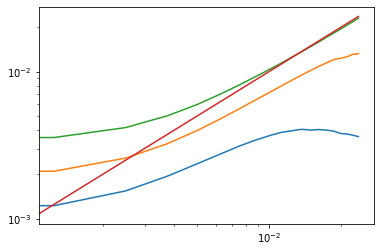

In [41]:
plt.figure(); plt.loglog(u_slopes, m_stats)
plt.loglog(u_slopes, u_slopes)

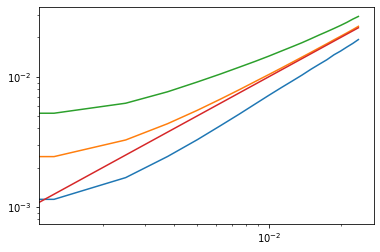

In [54]:

rounded_slope_v=np.round(vbar/slope_bin_width)*slope_bin_width
_, slope_bins = unique_by_rows(rounded_slope_v, return_dict=True)
u_slopes=np.array(list(slope_bins.keys()))
u_slopes=u_slopes[u_slopes<max_slope]
mv_stats=[]
for ii in range(u_slopes.size):
    mv_stats+= [sps.scoreatpercentile(m.slope[slope_bins[tuple([u_slopes[ii]])]], [16, 50, 84])]
mv_stats=np.r_[mv_stats]
plt.figure(); plt.loglog(u_slopes, mv_stats)
plt.loglog(u_slopes, u_slopes)

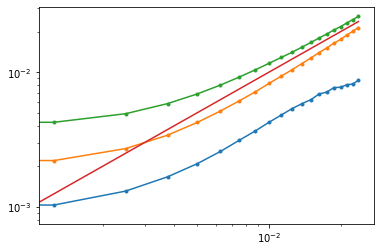

In [55]:
rounded_slope_v=np.round(v.slope_mag[:,1]/slope_bin_width)*slope_bin_width
_, slope_bins = unique_by_rows(rounded_slope_v, return_dict=True)
u_slopes=np.array(list(slope_bins.keys()))
u_slopes=u_slopes[u_slopes<max_slope]
mvv_stats=[]
for ii in range(u_slopes.size):
    mvv_stats+= [sps.scoreatpercentile(v.slope_mag[:,0][slope_bins[tuple([u_slopes[ii]])]], [16, 50, 84])]
mvv_stats=np.r_[mvv_stats]
plt.figure(); plt.loglog(u_slopes, mvv_stats, marker='.')
plt.loglog(u_slopes, u_slopes)

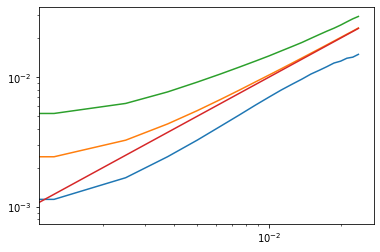

In [ ]:
max_slope=0.025
slope_bin_width=0.00125
slope_bin=np.round(meta.slope/slope_bin_width)*slope_bin_width

slope_vals, spread, N=spread_vs_slope(delta, slope_bin)
slope_fit=slope_regression(slope_vals[N>500], spread[N>500], max_slope)
to_plot = (N>500) & (slope_vals <0.05)
plt.figure(); plt.plot(slope_vals[to_plot], spread[to_plot],'.', label='data')
plt.plot(slope_vals[slope_vals < max_slope], slope_fit[1],'r', label='%3.3f + %3.2f|slope|' % tuple(slope_fit[0]))
plt.xlabel('slope magnitude')
plt.ylabel('xover difference spread')
plt.legend()
plt.title('all spots, cycle 09')


In [ ]:
slope_fit[0]
'%3.3f + %3.2f|slope|' % tuple(slope_fit[0])

In [ ]:
fits={}

for spot0 in range(1,7):
    for spot1 in range(1, spot0+1):
        #print((spot0, spot1))
        these = ((v.spot[:,0]==spot0) & (v.spot[:,1]==spot1)) | ((v.spot[:,0]==spot1) & (v.spot[:,1]==spot0))
        slope_vals, spread, N=spread_vs_slope(delta[these], slope_bin[these])
        fits[(spot0, spot1)]=slope_regression(slope_vals[N>100], spread[N>100], max_slope)[0]


In [ ]:
spots=np.c_[list(fits.keys())]
sigma_0=np.c_[[fits[tuple(spots[row,:])][0] for row in range(spots.shape[0])]]
sigma_x=np.c_[[fits[tuple(spots[row,:])][1] for row in range(spots.shape[0])]]

In [ ]:
plt.figure(); plt.scatter(spots[:,0], spots[:,1], 30, c=sigma_0, cmap='jet', vmin=0.045, vmax=0.1); 
plt.colorbar(label='flat-surface error, m')
plt.title('cycle 09')
plt.ylabel('spot')
plt.figure(); plt.scatter(spots[:,0], spots[:,1], 30, c=sigma_x, cmap='jet', vmin=2.5, vmax=8); 
plt.colorbar(label='pointing error, m')
plt.ylabel('spot')
plt.xlabel('spot')


# code to find per-rgt errors

In [ ]:
# error analysis to pick out the worst RGTs:
DD={}
sign=[1, -1]
dh_dict={}
y_atc_dict={}
spot_dict={}
dt_dict={}
for col in [0, 1]:
    # loop over combinations of cycles and tracks in each column
    u_ct, D_ct = unique_by_rows(np.c_[np.round(v.rgt[:, col]).astype(int), np.round(v.cycle_number[:,col]).astype(int)], return_dict=True)
    for ct in u_ct:
        key=tuple(ct)
        if key not in dh_dict:
            dh_dict[key]=[]
            y_atc_dict[key]=[]
            spot_dict[key]=[]
            dt_dict[key]=[]
        these=D_ct[key]
        good=(bar.atl06_quality_summary[these]<0.01) & (meta.slope_mag[these]<0.02)
        if np.any(good):
            dh_dict[key].append(delta.h_li[these[good]]*sign[col])
            y_atc_dict[key].append(v.y_atc[these,col][good])
            spot_dict[key].append(v.spot[these,col][good])
            dt_dict[key].append(v.delta_time[these,col][good])

In [ ]:
# make a dict holding per-rgt ct_stats_d

ct_stats_d={}
for key in dh_dict:
    if len(dh_dict[key]) ==0:
        continue
    dh=np.concatenate([item.ravel() for item in dh_dict[key]])
    spot=np.concatenate([item.ravel() for item in spot_dict[key]])
    y=np.concatenate([item.ravel() for item in y_atc_dict[key]])
    tt=np.concatenate([item.ravel() for item in dt_dict[key]])
    ct_stats_d[key]={
        'med':np.nanmedian(dh),
        'count':dh.size,
        'mad':np.nanmedian(np.abs(dh-np.nanmedian(dh))),
       'good_count':np.nansum(np.abs(dh)<1).astype(np.float),
        'y_atc':np.nanmean(y[np.abs(spot-3.5)<0.6]),
        't0':np.nanmin(tt),
        't1':np.nanmax(tt)}

In [ ]:
#flatten the ct_stats_dictionary

keys=list(ct_stats_d.keys())
ct_stats={
    'med':np.array([ct_stats_d[key]['med'] for key in keys]),
    'mad':np.array([ct_stats_d[key]['mad'] for key in keys]),
    'count':np.array([ct_stats_d[key]['count'] for key in keys]),
    'good_count':np.array([ct_stats_d[key]['good_count'] for key in keys]),
    'rgt':np.array([key[0] for key in keys]),
    'cycle':np.array([key[1] for key in keys]),
    'y':np.array([ct_stats_d[key]['y_atc'] for key in keys]),
    't0':np.array([ct_stats_d[key]['t0'] for key in keys]),
    't1':np.array([ct_stats_d[key]['t1'] for key in keys])
}

for field in ['med', 'mad', 'good_count']:
    ct_stats[field][ct_stats['count']<100]=np.NaN


In [ ]:
           
fig=plt.figure();
ax=fig.add_subplot(121)
ax.hist(np.log10(ct_stats['mad']), 25)
ax.set_xlabel('log10(MAD, m)')
ax=fig.add_subplot(122)
ax.hist(ct_stats['med'], 25)
ax.set_xlabel('med, m')

fig=plt.figure();
ax=fig.add_subplot(111)
ax.plot(ct_stats['rgt'], ct_stats['med'], 'k', label='medians')
ax.plot(ct_stats['rgt'], ct_stats['med']-ct_stats['mad'], 'r--', label='medians +- mads')
ax.plot(ct_stats['rgt'], ct_stats['med']+ct_stats['mad'] , 'r--')
ax.legend()
ax.set_xlabel('rgt')
ax.set_ylabel('xover differece, m')

print('found rgts with medians greater than 8 cm:')
print(ct_stats['rgt'][np.abs(ct_stats['med'])>0.08])

plt.show()


In [56]:
! ls /Volumes/ice2/ben/scf/Uyuni/003/xovers/


E0_N7700000.h5	E-100000_N7700000.h5  E100000_N7800000.h5
E0_N7800000.h5	E100000_N7700000.h5   E-100000_N7900000.h5
E0_N7900000.h5	E-100000_N7800000.h5  E100000_N7900000.h5


In [65]:
vu, du, bu, mu = read_xovers('/Volumes/ice2/ben/scf/Uyuni/003/xovers/', r_limits=[0, 1.e12], delta_t_limit=2592000)

In [67]:
vu=pc.data().from_dict(vu)
du=pc.data().from_dict(du)
bu=pc.data().from_dict(bu)

In [71]:
%matplotlib notebook

<IPython.core.display.Javascript object>


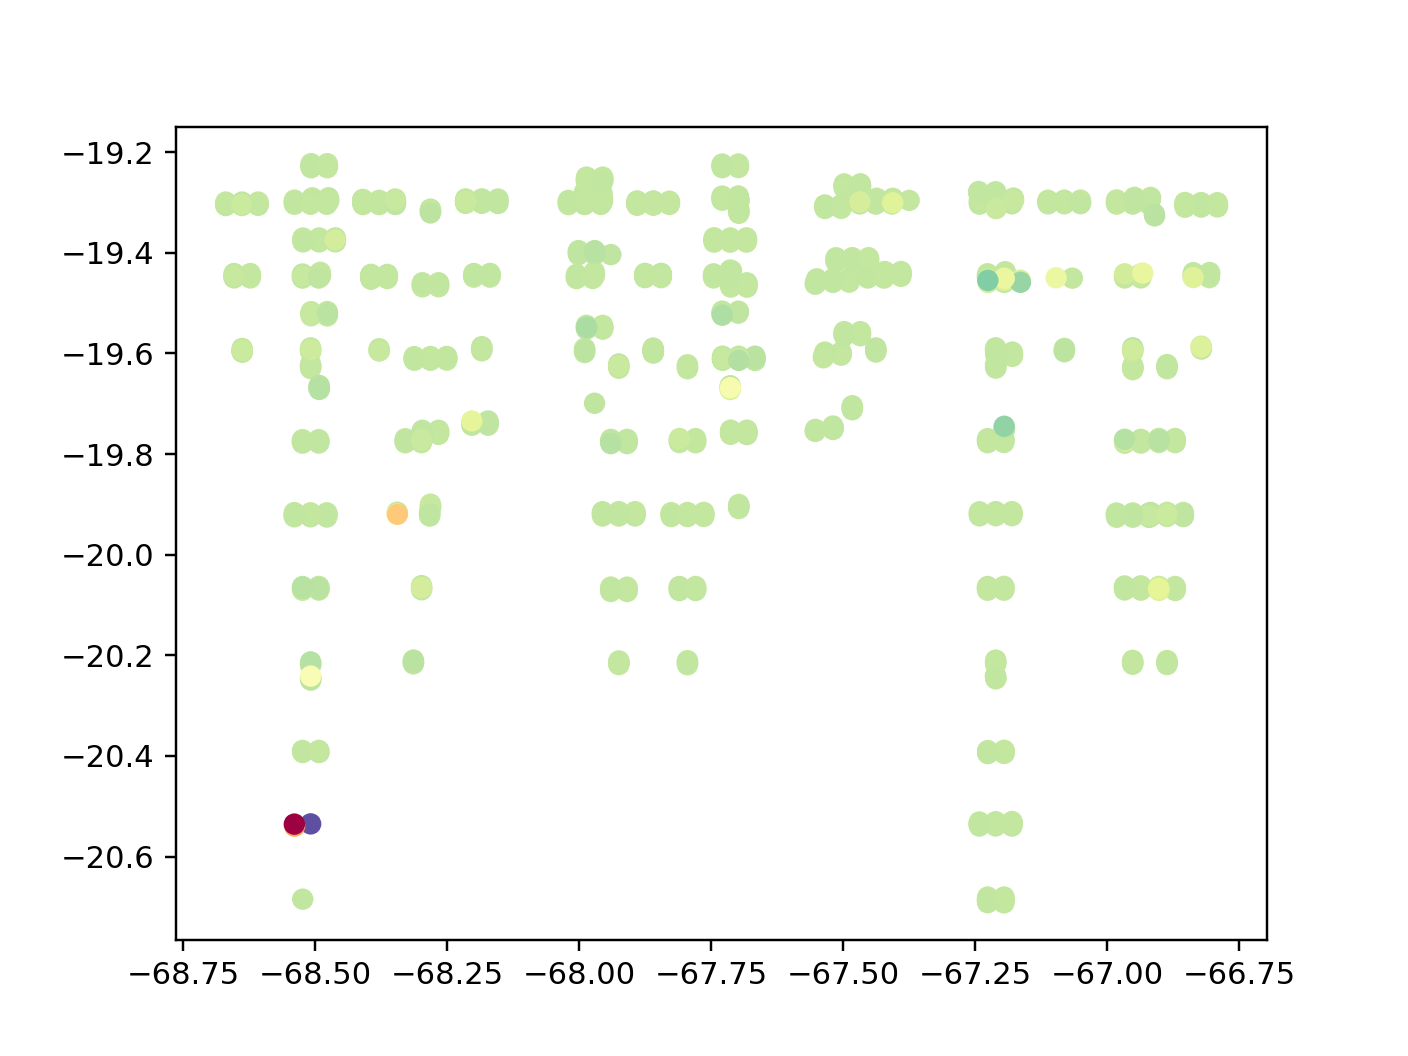

In [84]:
plt.figure(); 
ii=np.argsort(np.abs(du.h_li.ravel()))
plt.scatter(bu.longitude[ii], bu.latitude[ii], c=du.h_li[ii], clim=[-1, 1], cmap='Spectral')


In [83]:
vu

<class 'pointCollection.data.data'> with shape (914, 2),
with fields:
['BP', 'LR', 'W', 'atl06_quality_summary', 'bsnow_conf', 'bsnow_h', 'cloud_flg_asr', 'cloud_flg_atm', 'cycle_number', 'dac', 'delta_time', 'dh_fit_dx', 'dh_fit_dx_sigma', 'dh_fit_dy', 'h_li', 'h_li_sigma', 'h_mean', 'h_rms_misfit', 'h_robust_sprd', 'latitude', 'longitude', 'min_along_track_dh', 'n_fit_photons', 'n_pixels', 'r_eff', 'rgt', 'rss_along_track_dh', 'seg_azimuth', 'segment_id', 'sigma_geo_at', 'sigma_geo_h', 'sigma_geo_r', 'sigma_geo_xt', 'signal_selection_source', 'snr_significance', 'source_file_num', 'spot', 'tide_ocean', 'time', 'valid', 'w_surface_window_final', 'x', 'x_atc', 'y', 'y_atc']